# Centro Universitário Metodista Izabela Hendrix
## Ciências de Dados
### Professor: Rafael Glater
### Aluno: Nelson de Campos Nolasco
#### - Atividade 2 - Análise de sentimentos com Bag-of-Words

<center><h1>Análise de Sentimento usando Bag-of-Words</h1></center>

Nesta atividade, usaremos o mesmo dataset de reviews de filmes do IMDB, porém agora usaremos o dataset inteiro. 
Faça o download do dataset clicando <a href="https://drive.google.com/open?id=1yGrXcCu90adE08IHLUYLk5cIlfEj19r0">aqui</a>

Além disso, não vamos mais representar os reviews pelas features: 
<center><pre>[nº de palavras positivas, nº de palavras negativas]</pre></center>

Para saber em detalhes o formato do dataset, veja a atividade 1.

Vamos representar os reviews usando o modelo de bag-of-words, que consiste em representar os reviews através de vetores esparços. Onde cada posição do vetor representa uma possível palavra e o valor dessa posição representa a contagem das palavras presentes no review.

Suponhamos que os reviews abaixo sejam nosso dataset de treino:

<ul>
    <li>I like this movie.</li>
    <li>I did not like this movie.</li>
    <li>This movie is boring.</li>
    <li>This movie is awesome!</li>
</ul>

Após tratar todo o texto e tokenizá-lo, descobrimos que temos apenas 9 palavras possíveis:
<table style="border: 1px solid black; border-collapse: collapse;">
    <tr>
    <td style="border: 1px solid black">i</td>
    <td style="border: 1px solid black">like</td>
    <td style="border: 1px solid black">this</td>
    <td style="border: 1px solid black">movie</td>
    <td style="border: 1px solid black">did</td>
    <td style="border: 1px solid black">not</td>
    <td style="border: 1px solid black">is</td>
    <td style="border: 1px solid black">boring</td>
    <td style="border: 1px solid black">awesome</td>
    </tr>
</table>

Portanto, para representar o review <i>"I like this movie"</i> no modelo bag-of-words, teremos o seguinte vetor:

<table style="border: 1px solid black; border-collapse: collapse;">
    <tr>
    <td style="border: 1px solid black">i</td>
    <td style="border: 1px solid black">like</td>
    <td style="border: 1px solid black">this</td>
    <td style="border: 1px solid black">movie</td>
    <td style="border: 1px solid black">did</td>
    <td style="border: 1px solid black">not</td>
    <td style="border: 1px solid black">is</td>
    <td style="border: 1px solid black">boring</td>
    <td style="border: 1px solid black">awesome</td>
    </tr>
    <tr>
    <td style="border: 1px solid black"><center>1</center></td>
    <td style="border: 1px solid black"><center>1</center></td>
    <td style="border: 1px solid black"><center>1</center></td>
    <td style="border: 1px solid black"><center>1</center></td>
    <td style="border: 1px solid black"><center>0</center></td>
    <td style="border: 1px solid black"><center>0</center></td>
    <td style="border: 1px solid black"><center>0</center></td>
    <td style="border: 1px solid black"><center>0</center></td>
    <td style="border: 1px solid black"><center>0</center></td>
    </tr>
</table>

Precisamos então fazer os seguintes passos:
<ul>
    <li>Varrer todos os reviews, limpando o texto e fazendo a tokenização;</li>
    <li>Pegar cada palavra distinta dos reviews tokenizados para montar nosso vocabulário. O tamanho do vocabulário será o tamanho do vetor de entrada;</li>
    <li>Converter os reviews em vetores;</li>
    <li>Treinar um modelo classificador dando os vetores como entrada</li>
</ul>
    

In [0]:
#importando as bibliotecas
import re
import numpy as np
import random
import tensorflow as tf
import pandas as pd

## Lendo o dataset

Vamos criar uma função para carregar os reviews na memória. A função abre o arquivo de reviews e cria uma lista contendo os pares (label, review).

In [23]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [26]:
%cd gdrive/My\ Drive/

[Errno 2] No such file or directory: 'gdrive/My Drive/'
/content/gdrive/My Drive


In [27]:
%cd imdb_full

/content/gdrive/My Drive/imdb_full


In [0]:
def load_dataset(file_path):
    all_reviews = []
    with open(file_path) as f:
        for line in f:
            parts = line.strip('\n').split('\t')
            label = int(parts[1])
            review = parts[2]
            all_reviews.append((label, review))
    return all_reviews

In [29]:
train_reviews = load_dataset('train.txt')
test_reviews = load_dataset('test.txt')

# São de 25mil reviews de treino e 25mil de teste
print('N de reviews de treino:', len(train_reviews))
print('N de reviews de teste:', len(train_reviews))

# vejamos um review de treino
print(train_reviews[0])

('N de reviews de treino:', 25000)
('N de reviews de teste:', 25000)
(1, 'This is a true "80\'s movie": Back then they made maybe 100 times more movies than nowadays, and that makes many of them quite interesting... It was a cultural phenomenon, that don\'t exist anymore. Nowadays maybe the same kind of people that would have made cheap "straight-to-video"-movies in the eighties, are doing cheap porn. Porn seems to sell. Anyway, this is above the medium trash-movie level: It has good&fascinating story, and it\'s quite well made I think. In one scene you can even see the microphone swinging on the upper edge of the picture. Of course there are also little cameos by Ozzy and Gene Simmons, but they don\'t very much contribute to the film "success", although they are good in their small roles. The monster,heavy-singer "Sammi Curr", looks really terrible, especially when he\'s singing. One of the scariest monsters I\'ve seen in horror flicks. I may have nightmares of him next night. Not rec

## Limpando o texto

Vamos definir uma função que recebe um texto de review e retorna um texto todo em letras minúsculas, sem pontuação, sem tags HTML, etc:

In [0]:
def clean_text(text):
    text = text.lower()
    text = re.sub("([a-z])([A-Z])","\g<1> \g<2>", text)
    text = re.sub('\&[a-z]+;', '', text) # remove "Non-breaking space": &nbsp;
    text = text.replace('(', '')
    text = text.replace(')', '')
    text = text.replace('_', ' ')
    text = text.replace('-', ' ')
    text = text.replace('\'s', '')
    text = text.replace('\'', '')
    text = text.replace('!', '')
    text = text.replace('?', '')
    text = text.replace('.', '')
    text = text.replace(',', '')

    # remoção de "multiple spaces"
    text = re.sub(' +', ' ', text).strip()
    
    return text

In [33]:
print(train_reviews[0])

(1, 'This is a true "80\'s movie": Back then they made maybe 100 times more movies than nowadays, and that makes many of them quite interesting... It was a cultural phenomenon, that don\'t exist anymore. Nowadays maybe the same kind of people that would have made cheap "straight-to-video"-movies in the eighties, are doing cheap porn. Porn seems to sell. Anyway, this is above the medium trash-movie level: It has good&fascinating story, and it\'s quite well made I think. In one scene you can even see the microphone swinging on the upper edge of the picture. Of course there are also little cameos by Ozzy and Gene Simmons, but they don\'t very much contribute to the film "success", although they are good in their small roles. The monster,heavy-singer "Sammi Curr", looks really terrible, especially when he\'s singing. One of the scariest monsters I\'ve seen in horror flicks. I may have nightmares of him next night. Not recommended for intellectual movie lovers.')


## Criando o vocabulário

Vamos definir a função que irá receber como parâmetro o caminho do arquivo onde estão os reviews. Vamos ler cada linha do arquivo, pegando apenas o review e fazendo o tratamento de texto usando a função <i>clean_text</i> definida acima. Após a limpeza do texto, quebramos em tokens e armazenamos cada token em um <span style="color:blue"><i>set()</i></span> do python.

O <span style="color:blue"><i>set()</i></span> não permite itens repetidos, portanto é uma boa maneira de construírmos nosso vocabulário sem nos preocuparmos se determinado token (palavra) já foi inserida.

Além disso, vamos contar a frequência de cada palavra e armazenar um dict essa informação em um dict, onde a chave é a palavra e o valor é sua frequência:
<pre>counter['movie'] = 19324</pre>

Faremos isso para eliminar do nosso vocabulário palavras pouco frequentes!

<h4><span style="color: red">Complete a função abaixo:</span></h4>

In [0]:
def prepare_vocabulary(all_reviews):
    total = 0
    counter = {}
    vocab = set([]) # nao deixa repetir os tokens (??? dúvida - Nelson Nolasco)
    for label, review in all_reviews:
        clean_review = clean_text(review) # limpar o texto do review
        tokens = clean_review.split()
        for T in tokens: # lendo os tokens com "for"
            vocab.add(T) 
            total = total + 1 # Contando o número de tokens lidos
            if T in counter:
                counter[T] = counter[T]+1 
            else:
              counter[T] = 1 
    print('total de palavras lidas:', total) 

    return (vocab, counter)

In [35]:
vocab, counter = prepare_vocabulary(train_reviews)

# tamanho do vocabulário gerado
print('Tamanho do vocab:', len(vocab))

('total de palavras lidas:', 5869494)
('Tamanho do vocab:', 129631)


### Analisando o vocabulário

Ao executar a função acima, lemos um total de 5.8 milhões de palavras! Gerando um vocabulário de tamanho 129.631. Esse será o tamanho dos vetores para representar os reviews. Vamos reduzir o vocabulário removendo as palavras pouco frequentes. Vamos ver uma lista de palavras muito frequentes e pouco frequentes:

In [37]:
# vamos ordenar nossa contagem de frequência do maior pro menor
counter_sorted = sorted(counter.items(), key= lambda item: item[1], reverse=True)

counter_df = pd.DataFrame(counter_sorted)

# as 10 mais frequentes
display(counter_df.head(10))
# as 10 menos frequentes
display(counter_df.tail(10))

,0,1
0,the,324734
1,and,161777
2,a,160949
3,of,145289
4,to,135032
5,is,106482
6,in,92367
7,it,91881
8,this,72621
9,that,72212


,0,1
129621,gencon,1
129622,showi,1
129623,artbox,1
129624,suicide/murder,1
129625,mosaics,1
129626,helplol,1
129627,cast/crew,1
129628,manyand,1
129629,tabu<br,1
129630,footloose,1


Podemos ver que as palavras mais frequentes são stop-words e as menos frequentes apareceram apenas uma vez em todo o dataset. Em ambos os casos esses tipos de palavras acrescentam pouco significado para a classificação de reviews. 

Vamos deixar as stop-words no nosso vocabulário por equanto, mas vamos remover as palavras que apareceram 3 vezes ou menos ao longo do texto:

In [38]:
for word, count in counter.iteritems():
        if count <= 3:
            vocab.remove(word)
            
# vejamos agora o novo tamanho do vocab
print('Tamanho do vocab', len(vocab))

('Tamanho do vocab', 38576)


Só de remover as palavras pouco frequentes, reduzimos nosso vocabulário de 129 mil para 38 mil!

## Convertendo os reviews em vetores bag-of-words

O próximo passo é criar a função que irá converter os reviews em vetores BoW.

Vamos criar uma função auxiliar criará um dict que faz o mapeamento das palavras do vocabulário para a sua posição no vetor. Por exemplo, Seguindo o exemplo acima, temos um vetor de 9 posições, um para cada palavra possível:

<table style="border: 1px solid black; border-collapse: collapse;">
    <tr>
    <td style="border:1px solid black">i</td>
    <td style="border:1px solid black">like</td>
    <td style="border:1px solid black">this</td>
    <td style="border:1px solid black">movie</td>
    <td style="border:1px solid black">did</td>
    <td style="border:1px solid black">not</td>
    <td style="border:1px solid black">is</td>
    <td style="border:1px solid black">boring</td>
    <td style="border:1px solid black">awesome</td>
    </tr>
</table>

A função <span style="color:blue"><i>mapWords2Indexes</i></span> irá criar um mapeamento da palavra, para sua posiçao no vetor:
<pre>
word2Index['i'] = 0
word2Index['like'] = 1
...
word2Index['boring'] = 7
word2Index['awesome'] = 8
</pre>

Então, quando formos converter os tokens do review <span style="color: green"><i>["this", "movie", "is", "boring"]</i></span>. A forma mais prática é:

Criar um vetor de zeros, do tamanho do vocabulário:
<pre>[0, 0, 0, 0, 0, 0, 0, 0, 0]</pre>

E para cada token do review, olhamos o dict <i>word2Index</i> para saber em qual posição do vetor devemos somar 1. Ou seja, a primeira palavra <span style="color: green"><i>"this"</i></span> está na posição 2, e assim por diante. No final teremos o vetor:
<pre>[0, 0, 1, 1, 0, 0, 1, 1, 0]</pre>



In [0]:
def mapWords2Indexes(vocabulary): # função mapWords2Indexes para criar um mapeamento da palavra, para sua posiçao no vetor
    word2Index = {}
    for i, word in enumerate(vocabulary):
        word2Index[word] = i
    
    return word2Index

A função abaixo deve converter o texto de um review em sua representação vetorial. Ou seja, pegamos o texto do review, usamos a função <span style="color:blue"><i>clean_text</i></span> para limpá-lo, quebramos em tokens e retornamos um vetor (do tamanho do vocabulário) contendo a contagem de cada token do review.

<h4><span style="color: red">Complete a função abaixo:</span></h4>

In [0]:
def convert_to_vector(review_text, word2Index):
    vocab_size = len(word2Index)
    vector = np.zeros(vocab_size) # criando vetor de zero
    clean_review = clean_text(review_text) # limpando review_test
    tokens = clean_review.split() # tokezing
    for T in tokens:
        pos = word2Index[T]
        vector[pos] = vector[pos]+1  # vetor[0,0,0,0,0,0,] correndo os tokens e prever a posição pos=word2index[T] o +1 é para contar a repetição.
    
    return vector

Vamos executar a função auxiliar. Sua saída será usada mais adiante juntamente com a função convert_to_vector

In [54]:
word2Index = mapWords2Indexes(vocab) # mapeamento 

# vamos fazer um teste de conversão de review:
converted = np.asarray(convert_to_vector('I loved this movie so much ...', word2Index)) 
print(converted)
# posições do vetor que são diferentes de zero
print(np.where(converted > 0))

[0. 0. 0. ... 0. 0. 0.]
(array([  207,  4321, 15530, 21492, 34564, 37158]),)


## Usando o Keras

Iremos criar uma rede neural no keras com a seguinte estrutura:

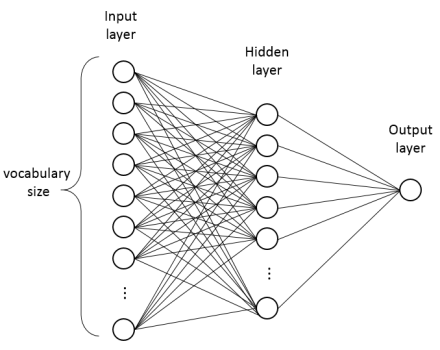

O Keras possui uma API que nos permite criar um modelo onde iremos adicionando as camadas sequencialmente. Começamos instanciando um modelo a partir da classe <i>Sequential</i>. Nossa primeira camada é a que irá receber os dados de entrada, portanto ela é do tipo <i>InputLayer</i> e tem o tamanho do nosso vetor BoW (que é do tamanho do vocabulário).

Em seguida, adicionamos ao modelo uma camada oculta com 20 neurônios e a função sigmoid como ativação. Por fim, temos nossa cama de saída, com apenas um neurônio (também ativado pela função sigmoid) que irá nos dizer se um review é positivo ou negativo.

Após definir todas as camadas do modelo, temos que definir a função de otimização (que no caso é o sgd - stochastic gradient descent), a função de perda (loss) e a métrica que usaremos para acompanhar a acurácia do modelo.

In [57]:
input_layer_size = len(vocab)

model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(input_layer_size,), dtype=tf.float32))
model.add(tf.keras.layers.Dense(20, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['binary_accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 20)                771540    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 771,561
Trainable params: 771,561
Non-trainable params: 0
_________________________________________________________________


### Lidando com a limitação de memória

Temos nossos reviews de treino e de teste guardados em memória nas listas <i>train_reviews</i> e <i>test_reviews</i> respectivamente. Acontece que, se tentarmos converter todos nossos reviews de treino em vetores bag-of-words de uma vez só, não irá caber na memória. Pois a dimensão dos vetores é muito alta e temos 25mil reviews! Temos então que criar uma função geradora que irá convertendo os reviews à medida que precisarmos. Essa função recebe os reviews que estão na memória e converte a quantidade definida pelo parâmetro <i>batch_size</i> e retorna a lista de reviews convertidos.

In [0]:
def batch_generator(all_reviews, word2Index, batch_size):
    batch_labels = []
    batch_reviews = []
    while True:
        random.shuffle(all_reviews)
        for label, review in all_reviews:
            vector = convert_to_vector(review, word2Index)
            batch_labels.append([label])
            batch_reviews.append(vector)
            if len(batch_labels) >= batch_size:
                yield np.asarray(batch_reviews), np.asarray(batch_labels)
                batch_labels = []
                batch_reviews = []
        if len(batch_labels) > 0:
            yield np.asarray(batch_reviews), np.asarray(batch_labels)

### Treinando o modelo

Para treinar um modelo no Keras, basta usar o método <span style="color: blue"><i>fit()</i></span> (quando o dado de treino cabe todo na memória) ou o método <span style="color: blue"><i>fit_generator()</i></span> (para quando todo o dado de treino não cabe na memória).

Para o método <span style="color: blue"><i>fit()</i></span> passamos diretamente os reviews e os labels, dessa forma:
<pre>model.fit(x=reviews_text, y=reviews_labels, ...)</pre>

Para o método <span style="color: blue"><i>fit_generator()</i></span> passamos a função geradora (que criamos acima) que irá fornecer os dados à medida que o modelo for treinando. 
<ul>
    <li><b>epochs:</b> O número de épocas (epochs) define quantas vezes iremos passar por todo o dataset de treino.</li>
    <li><b>steps_per_epoch:</b> Como estamos usando uma função geradora, o Keras não sabe exatamente o tamanho do nosso dado e portanto temos que informar pra ele o parâmetro steps_per_epoch, que diz quantos passos ele deve dar pra ler o dataset completo. No nosso caso temos 25mil exemplos de treino, e estamos lendo 100 exemplos por vez (batch_size), isso quer dizer, que para ler todos os dados, ele deve dar um total de 250 passos.
</ul>

In [0]:
history = model.fit_generator(
    batch_generator(train_reviews, word2Index, batch_size=100), 
    epochs=5, steps_per_epoch=250, verbose=1
)

### Testando o modelo

Para avaliar um modelo no keras basta usar o método <span style="color:blue"><i>evaluate()</i></span> ou <span style="color:blue"><i>evaluate_generator()</i></span> seguindo a mesma ideia que vimos nos métodos fit de treino.

In [0]:
results = model.evaluate_generator(batch_generator(test_reviews, word2Index, 1000), steps=25)
for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

## Usando o Tensorflow

Usar o Keras é bem simples. Mas pouco flexível. Vejamos como fazer o treino e o teste usando o Tensorflow:

In [0]:
input_layer_size = len(vocab)
hidden_layer_size = 20
output_layer_size = 1

# declare network variables
X = tf.placeholder(tf.float32, shape=[None, input_layer_size])
y = tf.placeholder(tf.float32, shape=[None, output_layer_size])

# neural network layers
hidden_layer1 = tf.layers.dense(inputs=X, units=hidden_layer_size, activation=tf.nn.sigmoid)
output_layer = tf.layers.dense(inputs=hidden_layer1, units=output_layer_size)

# loss and optimization
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=output_layer))
train_op = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss_op)

# Accuracy calculation
correct_prediction = tf.equal(tf.round(tf.nn.sigmoid(output_layer)), y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# initialize network weights
init = tf.global_variables_initializer()

In [0]:
def batch_generator_tensorflow(all_reviews, word2Index, batch_size):
    batch = [[], []] # [labels], [reviews]
    for label, review in all_reviews:
        vector = convert_to_vector(review, word2Index)
        batch[0].append([label])
        batch[1].append(vector)
        if len(batch[0]) >= batch_size:
            yield batch
            batch = [[], []]
    if len(batch[0]) > 0:
        yield batch

In [0]:
epochs = 10
with tf.Session() as sess:
    sess.run(init)
    for e in xrange(epochs):
        random.shuffle(train_reviews)
        avg_loss = 0.0
        num_batches = 0.0
        avg_acc = 0.0
        for label, review_vector in batch_generator_tensorflow(train_reviews, word2Index, batch_size=100):
            num_batches += 1.0
            Xi = np.array(review_vector)
            yi = np.array(label)
            _, l, acc = sess.run([train_op, loss_op, accuracy],feed_dict={X:Xi,y:yi})
            avg_loss += l
            avg_acc += acc


        avg_loss = avg_loss / num_batches
        avg_acc = avg_acc / num_batches
        print "Epoch: {0} - cost: {1}, accuracy: {2}".format(e, avg_loss, avg_acc)


    num_batches = 0.0
    avg_acc = 0.0
    for label, review_vector in batch_generator_tensorflow(test_reviews, word2Index, batch_size=1000):
        num_batches += 1.0
        Xi = np.array(review_vector)
        yi = np.array(label)
        acc = accuracy.eval(feed_dict={X:Xi, y:yi})
        avg_acc += acc
    avg_acc = avg_acc / num_batches
    print 'Test accuracy:', avg_acc